In [1]:
%pip install -r requirements.txt


In [2]:
import os
from pathlib import Path

from dotenv import load_dotenv
from stable_baselines3 import PPO
from envionments.threshold_refinement import ThresholdRefinementEnv
from utility.dataset import load_pascal_voc2007, load_custom_dataset

load_dotenv()

VOC_ROOT = os.getenv("VOC_ROOT", "data/voc")
IMAGE_DIR = os.getenv("IMAGE_DIR")
LABEL_DIR = os.getenv("LABEL_DIR")
DATA_LIMIT = int(os.getenv("RL_DATA_LIMIT", "500"))
TOTAL_TIMESTEPS = int(os.getenv("RL_TOTAL_TIMESTEPS", "20000"))
LEARNING_RATE = float(os.getenv("RL_LEARNING_RATE", "3e-4"))
MODEL_PATH = os.getenv("RL_MODEL_PATH", "rl_threshold_tuner.zip")

if IMAGE_DIR:
    dataset = load_custom_dataset(
        IMAGE_DIR,
        LABEL_DIR or IMAGE_DIR,
        annotation_format="yolo_txt",
        limit=DATA_LIMIT,
    )
else:
    dataset = load_pascal_voc2007(
        VOC_ROOT, image_set="trainval", limit=DATA_LIMIT, download=True
    )

env = ThresholdRefinementEnv(dataset)

if Path(MODEL_PATH).exists():
    model = PPO.load(MODEL_PATH)
    model.set_env(env)
    print(f"Loaded existing model from {MODEL_PATH}")
else:
    model = PPO("MlpPolicy", env, verbose=1, learning_rate=LEARNING_RATE, n_steps=512)
    model.learn(total_timesteps=TOTAL_TIMESTEPS)
    model.save(MODEL_PATH)
    print(f"Trained and saved model to {MODEL_PATH}")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loaded existing model from rl_threshold_tuner.zip


{'episodes': 5, 'mean_final_iou': 0.7630466222763062, 'std_final_iou': 0.23211872577667236, 'mean_return': 0.7630466222763062, 'mean_steps': 3.5999999046325684}


<Axes: title={'center': 'Threshold trajectory per evaluation episode'}, xlabel='Step', ylabel='Confidence threshold'>

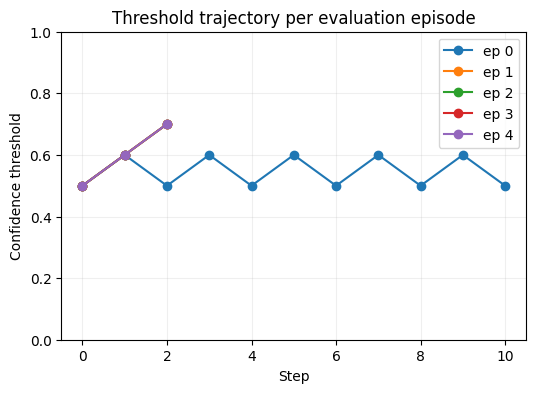

In [3]:
import os

from dotenv import load_dotenv
from utility.evaluation import evaluate_policy, summarize_stats, plot_threshold_trajectories

load_dotenv()
EVAL_EPISODES = int(os.getenv("RL_EVAL_EPISODES", "5"))

stats = evaluate_policy(model, dataset, episodes=EVAL_EPISODES)
summary = summarize_stats(stats)
print(summary)

plot_threshold_trajectories(stats)


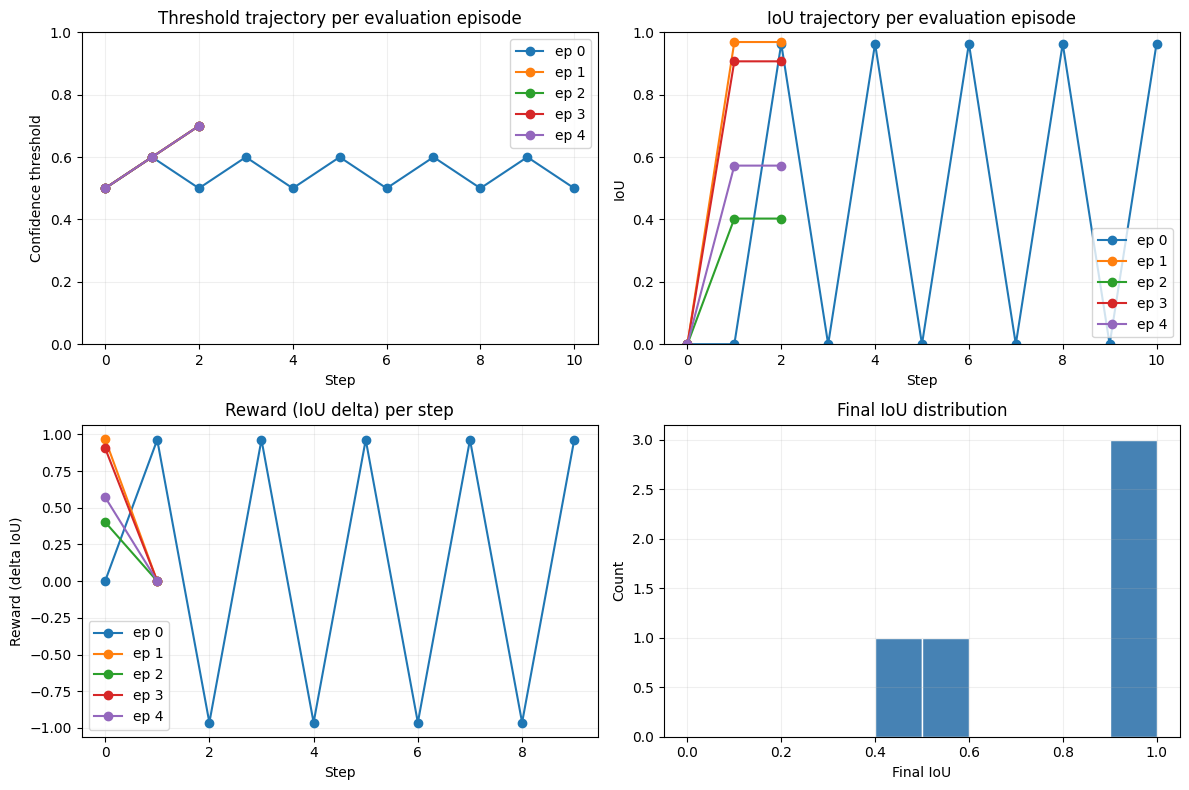

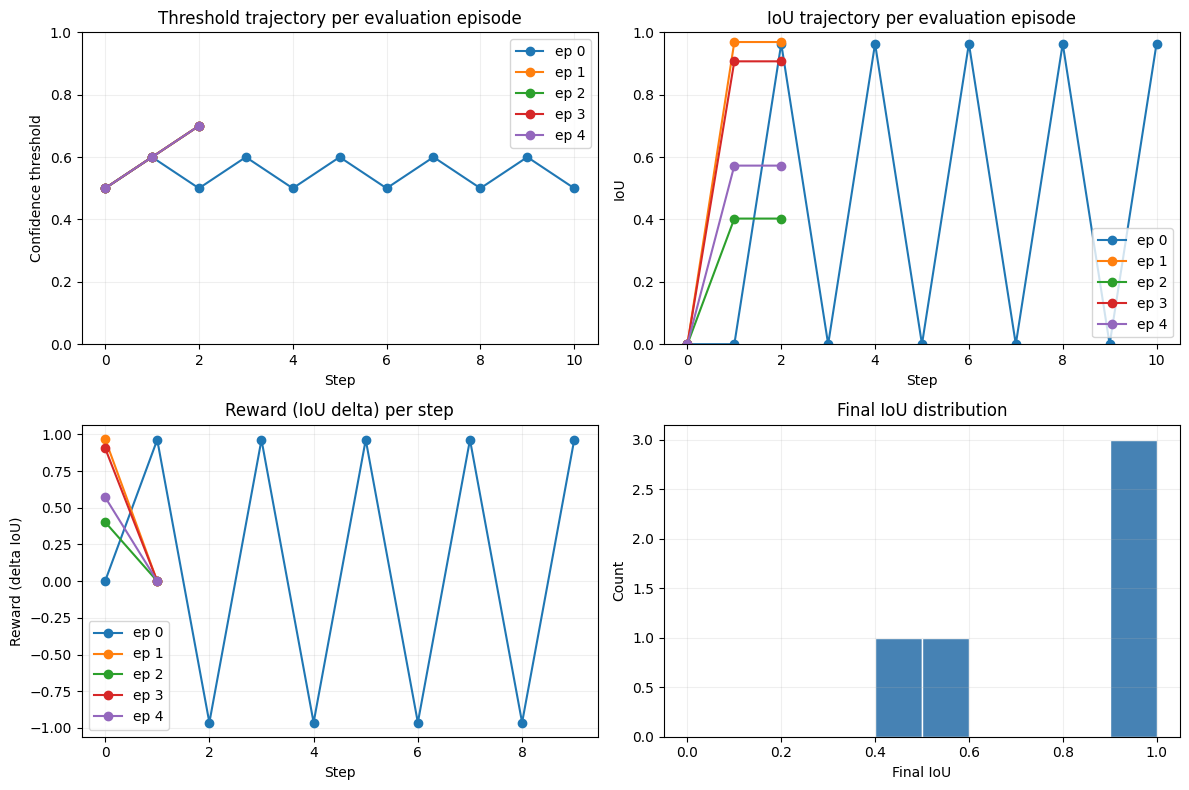

In [4]:
import matplotlib.pyplot as plt
from utility.evaluation import (
    plot_threshold_trajectories,
    plot_iou_trajectories,
    plot_reward_trajectories,
    plot_final_iou_histogram,
)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_threshold_trajectories(stats, ax=axes[0, 0])
plot_iou_trajectories(stats, ax=axes[0, 1])
plot_reward_trajectories(stats, ax=axes[1, 0])
plot_final_iou_histogram(stats, ax=axes[1, 1])
plt.tight_layout()
fig


## Compare RL policy vs baseline YOLO

Run the saved PPO checkpoint against fixed-threshold YOLOv8n.


In [ ]:
import json
from utility.model_comparison import compare_models

comparison = compare_models(
    model_path=MODEL_PATH,
    episodes=1,
    dataset_limit=10,
    thresholds=[0.5],
)
print(json.dumps(comparison, indent=2))
